Visoelastic Data Viewer

In [ ]:
from pvc_tensile_experiment.Functions import *

# set desired plasticizer
for plastiRatio in ['P2']:#, 'P4', 'P6', 'P8']:
   ViscoelasticDataViewer(plastiRatio)

Stress Relaxation Parameter Boundary Estimation

SLS Model [533502.19604027  43695.66694217   1019.96350353] 0.9788 

Prony 2-Term Model [5.28317870e+05 3.70539014e+04 1.80824256e+03 2.76521827e+04
 1.37500451e+02] 0.989 

Prony 3-Term Model [5.28236028e+05 3.64932077e+04 1.83435137e+03 2.20870655e+04
 1.73721209e+02 3.54441573e+04 2.46693546e+01] 0.9925 



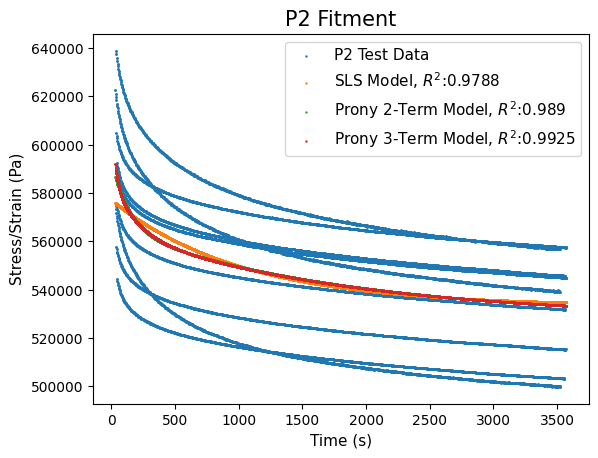

In [59]:
import numpy as np; import os
import matplotlib.pyplot as plt
import scipy.optimize as opt
from pvc_tensile_experiment.Functions import *


modelBoundaries = list([[(1e5, 1e6), (0.5e4, 1e5), (500, 1200)], # SLS
                        [(1e5, 1e6), (0.5e4, 1e5), (1000, 2000), (1e3, 1e5), (50, 200)], # Proney 2 term
                        [(1e5, 1e6), (0.5e4, 1e5), (1000, 2000), (1e3, 1e5), (90, 200), (1e3, 1e5), (20, 100)] # Proney 3 term
                        ])


def StressRelaxFitting(modelBoundaries, plastiRatio):
    # these equations are normalized to stress/strain
    def SLS(params, t):
        EInf, E1, tau = params
        return EInf + E1*np.exp(-t/tau)

    def Prony2Term(params, t):
        EInf, E1, tau1, E2, tau2 = params
        return EInf + E1*np.exp(-t/tau1) + E2*np.exp(-t/tau2)

    def Prony3Term(params, t):
        EInf, E1, tau1, E2, tau2, E3, tau3 = params
        return EInf + E1*np.exp(-t/tau1) + E2*np.exp(-t/tau2) + E3*np.exp(-t/tau3)

    def RSquared(yTrue, yPredict):
        ssResidual = np.sum((yTrue - yPredict)**2)
        ssTotal = np.sum((yTrue - np.mean(yTrue))**2)
        return 1 - (ssResidual/ssTotal)


    # define the model fitting function
    def FitModel(model, t, stress, boundaries):
        # define the residual function and the NRMS function
        def Residuals(params):
            return model(params, t) - stress

        def NRMS(params):
            return np.sqrt(np.mean(Residuals(params)**2))/np.sqrt(np.mean(stress**2))

        # run the genetic algorithm first and use the results for the levenberg-marquardt solution
        optParams = opt.differential_evolution(NRMS, bounds = boundaries, popsize = 100).x
        return optParams

    # models and initial guesses
    models = {
        "SLS Model": (SLS, modelBoundaries[0]),
        "Prony 2-Term Model": (Prony2Term, modelBoundaries[1]), 
        "Prony 3-Term Model": (Prony3Term, modelBoundaries[2])
        }
    
    # plot parameters
    markerSize = 0.5
    titleSize = 15
    axisSize = 11
    legendSize = 11

    # define the folder name and pull the files that end with xlsx
    fileNames = [i for i in os.listdir(f'Data/Viscoelastic Data/Stress Relaxation Data') if i.endswith('.xlsx') and i.find(plastiRatio) != -1]

    # store the elongation regions to determine the coefficient of determination
    Data = np.zeros([0, 4])

    # define a dictionary to store the model coefficient
    fitResults = {}
    rSquared = []


    for name, (model, boundaries) in models.items():
        # determine the length of the coefficient parameters
        coefficientParameters = len(boundaries)

        # define array for the average coefficients from all datasets
        FitCoefficients = np.zeros([0, coefficientParameters])
        
        for i in fileNames:
            # read and process the data file for strain and stress 
            expTime, strain, _, stress = ViscoelasticDataProcessor('Stress Relaxation Data', i)
            regions = StressRelaxationRegionSelector(strain)

            for j in range(0, 3):
                # extract the increasing strain regions
                indexRange = range(regions[0, j], regions[1, j])
                
                # get the stress vector offset
                expTimeOffset = expTime[indexRange][0]
                stressOffset = stress[indexRange][0]
                strainOffset = strain[indexRange][0]
                
                # reset the index range to not include the first 2 data points, removing the non values.
                indexRange =  range(regions[0, j] + 7, regions[1, j])

                # define the variables 
                expTimeFit = expTime[indexRange] - expTimeOffset
                strainFit = strain[indexRange] - strainOffset
                stressFit = stress[indexRange] - stressOffset
                normStressFit = stressFit/strainFit

                # fit each data set for normalized stress
                for i in range(0, 3):
                    params = FitModel(model, expTimeFit, normStressFit, boundaries)
                    FitCoefficients = np.vstack([FitCoefficients, params])
                    rSquared.append(RSquared(normStressFit, models[name][0](params, expTimeFit)))

                # store stress and strain into arrays for data fitting.
                Data = np.vstack([Data, np.array([expTimeFit, strainFit, stressFit, normStressFit]).T])

        # sort data based on time 
        Data = Data[Data[::, 0].argsort()]

        # average the fitted coefficients and store them
        fitResults[name] = (np.mean(FitCoefficients, axis = 0), np.round(np.mean(rSquared), 4))

        # show the results
        print(name, fitResults[name][0], fitResults[name][1], '\n')


    # plot the fitment region
    plt.scatter(Data[::, 0], Data[::, 3], s = markerSize, label = f'{plastiRatio} Test Data')
   
    # plot the model
    for name, (params) in fitResults.items():
        plt.scatter(Data[::, 0], models[name][0](fitResults[name][0], Data[::, 0]), s = markerSize, label = f'{name}, $R^2$:{fitResults[name][1]}')
        plt.xlabel('Time (s)', fontsize = axisSize)
        plt.ylabel('Stress/Strain (Pa)', fontsize = axisSize)
        plt.title(f'{plastiRatio} Fitment', fontsize = titleSize)
        plt.legend(fontsize = legendSize)
    return Data, fitResults

plastiRatio = 'P2'
Data, fitResults = StressRelaxFitting(modelBoundaries, plastiRatio)

MISC. & Old Functions

Viscoelastic Monotonic Strain Rate Fitting

In [ ]:
import numpy as np; import os
import matplotlib.pyplot as plt
import scipy.optimize as opt
from pvc_tensile_experiment.Functions import *


def MonotonicStressFitting(modelBoundaries, plastiRatio):
    # define the SLS, Prony series, and coefficient of determination functions
    # these are in terms of stress
    def SLSStrainRate(params, strain):
        EInf, E1, tau = params
        return EInf*strain + E1*tau*strainRateFit*(1 - np.exp(-strain/(tau*strainRateFit))) 

    def Prony2TermStrainRate(params, strain):
        EInf, E1, tau1, E2, tau2 = params

        return (EInf*strain +
                E1*tau1*strainRateFit*(1 - np.exp(-strain/(tau1*strainRateFit))) +
                E2*tau2*strainRateFit*(1 - np.exp(-strain/(tau2*strainRateFit))))

    def Prony3TermStrainRate(params, strain):
        EInf, E1, tau1, E2, tau2, E3, tau3 = params
        return (EInf*strain +
                E1*tau1*strainRateFit*(1 - np.exp(-strain/(tau1*strainRateFit))) +
                E2*tau2*strainRateFit*(1 - np.exp(-strain/(tau2*strainRateFit))) +
                E3*tau3*strainRateFit*(1 - np.exp(-strain/(tau3*strainRateFit))))

    def RSquared(yTrue, yPredict):
        ssResidual = np.sum((yTrue - yPredict)**2)
        ssTotal = np.sum((yTrue - np.mean(yTrue))**2)
        return 1 - (ssResidual/ssTotal)

    # define the model fitting function
    def FitModel(model, strain, stress, boundaries):
        # define the residual function and the NRMS function
        def Residuals(params):
            return model(params, strain) - stress

        def NRMS(params):
            return np.sqrt(np.mean(Residuals(params)**2))/np.sqrt(np.mean(stress**2))

        # run the genetic algorithm first and use the results for the levenberg-marquardt solution
        optParams = opt.differential_evolution(NRMS, bounds = boundaries, popsize = 100).x
        return optParams

    # models and initial guesses
    models = {
        "SLS Model": (SLSStrainRate, modelBoundaries[0]),
        "Prony 2-Term Model": (Prony2TermStrainRate, modelBoundaries[1]), 
        "Prony 3-Term Model": (Prony3TermStrainRate, modelBoundaries[2])
        }


    # define the folder name and pull the files that end with xlsx
    fileNames = [i for i in os.listdir('Data/Viscoelastic Data/Monotonic Strain Rate Data') if i.endswith('.xlsx') and i.find(plastiRatio) != -1]

    # store the elongation regions to determine the coefficient of determination
    Data = np.zeros([0, 3])

    # define a dictionary to store the model coefficient
    fitResults = {}
    rSquared = []

    # plot parameters
    markerSize = 0.5
    titleSize = 15
    axisSize = 11
    legendSize = 11

    for name, (model, boundaries) in models.items():
        # determine the length of the coefficient parameters
        coefficientParameters = len(boundaries)

        # define array for the average coefficients from all datasets
        FitCoefficients = np.zeros([0, coefficientParameters])

        # read each file, extracting the increasing strain region and save all to a set of arrays
        for i in fileNames:
            # read and process the data file for strain and stress 
            _, strain, strainRate, stress = ViscoelasticDataProcessor('Monotonic Strain Rate Data', i)

            # find each strain amplitude region
            regions = MonotonicStrainRateRegionSelector(strain)
            
            for j in range(0, 3):
                # extract the increasing strain regions
                indexRange = range(regions[0, j], regions[1, j])
                strainFit = strain[indexRange] - strain[indexRange][0]
                strainRateFit = strainRate[indexRange]
                stressFit = stress[indexRange] - stress[indexRange][0]

                # store stress and strain into arrays for data fitting.
                Data = np.vstack([Data, np.array([strainFit, strainRateFit, stressFit]).T])
                    
                
                for i in range(0, 3):
                    # run the data fitment for increasing strain regions
                    params = FitModel(model, strainFit, stressFit, boundaries)
                    FitCoefficients = np.vstack([FitCoefficients, params])
                    rSquared.append(RSquared(stressFit, models[name][0](params, strainFit)))

            
        # average the fitted coefficients
        params = np.average(FitCoefficients, axis = 0)

        # redefine the strainRateFit from the stored data. its passed to make sure the functions work
        fitResults[name] = (params, np.round(np.mean(rSquared), 4))
        
        # show the results
        print(name, fitResults[name][0], fitResults[name][1], '\n')


    # average the strain rate for the functions
    strainRateFit = np.average(Data[::, 1])

    # plot data results
    plt.scatter(Data[::, 0], Data[::, 2], s = markerSize, color = "black")

    for name, (params) in fitResults.items():
        plt.scatter(Data[::, 0], models[name][0](fitResults[name][0], Data[::, 0]), s = markerSize, label = f'{name}, $R^2$:{fitResults[name][1]}')
        plt.xlabel('Strain (m/m)', fontsize = axisSize)
        plt.ylabel('Stress (Pa)', fontsize = axisSize)
        plt.title(f'{plastiRatio} Fitment', fontsize = titleSize)
        plt.legend(fontsize = legendSize)
    return Data, fitResults

Data, fitResults = MonotonicStressFitting(modelBoundaries, 'P2')

Stress Relaxation Verification

In [ ]:
def StressRelaxation(plastiRatio, fitResults):
        # these equations are normalized to stress/strain
    def SLS(params, t):
        EInf, E1, tau = params
        return EInf + E1*np.exp(-t/tau)

    def Prony2Term(params, t):
        EInf, E1, tau1, E2, tau2 = params
        return EInf + E1*np.exp(-t/tau1) + E2*np.exp(-t/tau2)

    def Prony3Term(params, t):
        EInf, E1, tau1, E2, tau2, E3, tau3 = params
        return EInf + E1*np.exp(-t/tau1) + E2*np.exp(-t/tau2) + E3*np.exp(-t/tau3)

    def RSquared(yTrue, yPredict):
        ssResidual = np.sum((yTrue - yPredict)**2)
        ssTotal = np.sum((yTrue - np.mean(yTrue))**2)
        return 1 - (ssResidual/ssTotal)


    # define the folder and find the files for strain relaxation
    folderName = 'Stress Relaxation Data'
    fileNames = [i for i in os.listdir(f'Data/Viscoelastic Data/{folderName}') if i.endswith('.xlsx') and i.find(plastiRatio) != -1]

    # preallocate the total data matrix
    Data = np.zeros([0, 4])

    # plot parameters
    markerSize = 0.5
    titleSize = 15
    axisSize = 11
    legendSize = 11
    
    for i in fileNames:
        # read and process the data file for strain and stress 
        expTime, strain, _, stress = ViscoelasticDataProcessor('Stress Relaxation Data', i)
        regions = StressRelaxationRegionSelector(strain)

        for j in range(0, 3):
            # extract the increasing strain regions
            indexRange = range(regions[0, j], regions[1, j])
            
            # get the stress vector offset
            expTimeOffset = expTime[indexRange][0]
            stressOffset = stress[indexRange][0]
            strainOffset = strain[indexRange][0]
            
            # reset the index range to not include the first 2 data points, removing the non values.
            indexRange =  range(regions[0, j] + 7, regions[1, j])

            # define the variables 
            expTimeFit = expTime[indexRange] - expTimeOffset
            strainFit = strain[indexRange] - strainOffset
            stressFit = stress[indexRange] - stressOffset
            normStressFit = stressFit/strainFit

            # store stress and strain into arrays for data fitting.
            Data = np.vstack([Data, np.array([expTimeFit, strainFit, stressFit, normStressFit]).T])

    expTimeFit = Data[::, 0]
    strainFit = Data[::, 1]
    stressFit = Data[::, 2]
    normStressFit = Data[::, 3]

    # plot the fitment region
    plt.scatter(expTimeFit, normStressFit, s = markerSize, label = f'{plastiRatio} Test Data')

    # plot the fit results for each function
    plt.scatter(expTimeFit, SLS(fitResults['SLS Model'][0], expTimeFit), s = 2, label = 'SLS')
    print(RSquared(normStressFit, SLS(fitResults['SLS Model'][0], expTimeFit)))

    plt.scatter(expTimeFit, Prony2Term(fitResults['Prony 2-Term Model'][0], expTimeFit), s = 2, label = 'Prony 2 Term')
    print(RSquared(normStressFit, Prony2Term(fitResults['Prony 2-Term Model'][0], expTimeFit)))
    
    plt.scatter(expTimeFit, Prony3Term(fitResults['Prony 3-Term Model'][0], expTimeFit), s = 2, label = 'Prony 3 Term')
    print(RSquared(normStressFit, Prony3Term(fitResults['Prony 3-Term Model'][0], expTimeFit)))

    plt.xlabel('Time (s)', fontsize = axisSize)
    plt.ylabel('Stress (Pa)/Strain', fontsize = axisSize)
    plt.title(f'{fileNames[0].removesuffix('.xlsx').split('_')[0]} Fit', fontsize = titleSize)
    plt.legend(fontsize = legendSize)


StressRelaxation('P2', fitResults)